# Building regularized softmax regression model for CIFAR10 using PyTorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import top_k_accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [2]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

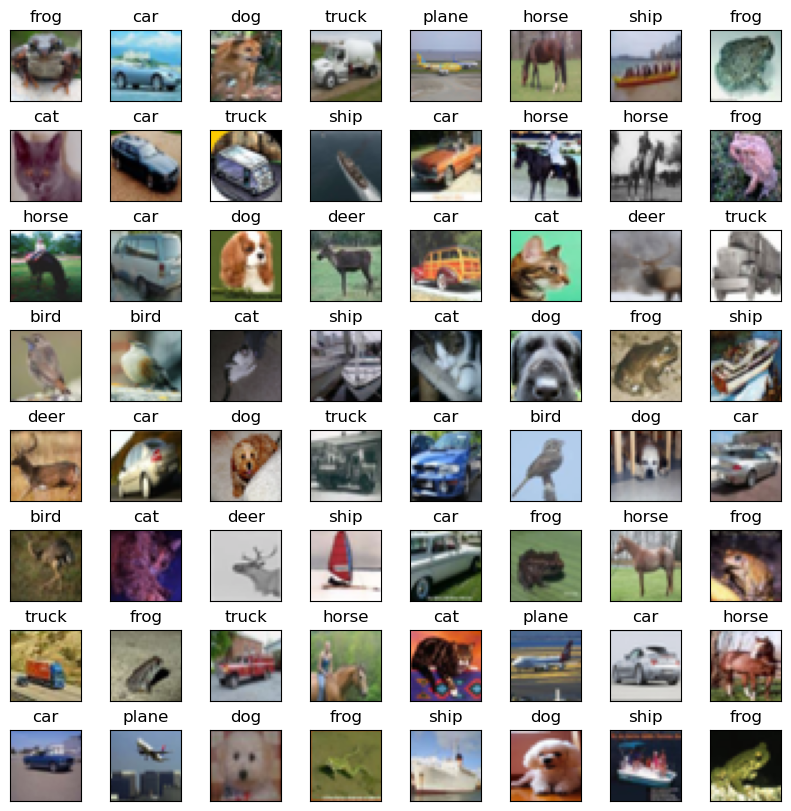

In [3]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# The softmax function

In [4]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

# The SoftmaxRegression model (20 points)
- the __init__ function takes the number of inputs, number of outputs, a learning rate lr, and a weight decay wd (L2 regularization strength).
     - set the learning rate and weight decay of the model
     - build the network using torch.nn.Sequential() composed of the Flatten() function and a Linear() layer with num_inputs and num_outputs.
     - initialize the weights of the linear layer from a zero-mean Gaussian with noise=0.01. You can access the linear layer as self.net[1]
     - initialize the bias of the linear layer to be 0
     
- the forward function returns the softmax of the affine transform of the flattened input with the linear layer
- the loss function reshapes the prediction yhat and the true labels y into 1D tensors, and then calls the built in torch.nn.functional.cross_entropy() function to calculate the softmax loss with reduction = 'mean' if averaged is set to True.
- the predict function takes a batch of images X and runs the forward function to get the softmax, and return the index of the class with the highest probability (use .argmax())
- the configure_optimizers function that is a call to torch.optim.SGD() specifying the parameters to be updated, the weight decay, and the learning rate.


In [5]:
class SoftmaxRegression(nn.Module):
    def __init__(self,num_inputs,num_outputs,lr, wd):
        super().__init__()
        # YOUR CODE HERE (about 5 lines)
        self.lr = lr
        self.wd = wd
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_outputs)) # define process
        self.net[1].weight.data.normal_(0, 0.01) # initialize weights as Gaussian with variance 0.01
        self.net[1].bias.data.fill_(0) # start bias at 0

    def forward(self,X):
        # YOUR CODE HERE (1 line)
        return self.net(X)

    def loss(self,yhat,y,averaged=True):
        # YOUR CODE HERE (about 2-3 lines)
        Y_hat = yhat.reshape((-1, yhat.shape[-1]))
        Y = y.reshape((-1,))
        L2 = 0.5 * self.wd * torch.sum(torch.square(self.net[1].weight))
        return F.cross_entropy(Y_hat, Y, reduction = 'mean' if averaged else 'none') + L2

    def predict(self,X):
        # YOUR CODE HERE (1 line)
        logits = self.forward(X)
        probs = softmax(logits)
        return probs.argmax()

    def configure_optimizers(self):
        # YOUR CODE HERE (1 line)
        return torch.optim.SGD(self.parameters(), self.wd, self.lr)


# The training loop (50 points)

Complete the implementation of the function train_model which takes an initialized softmax model, a train set loader, a val set loader, and the number of epochs to train.

- Initialize train_loss and val_loss tensors to store the training set and val set losses for each epoch. We will plot them at the end
- Configure the optimizer associated with the model
- for each epoch until num_epochs do:
    - initialize a running train loss and a running val loss (so we can accumulate losses over each batch)
    - for each (X,y) in trainloader:
         - zero gradients in optimizer
         - compute output of model on X
         - compute loss on output and y
         - perform backward() step on loss
         - update parameters with optimizer.step()
         - accumulate running train loss with loss
    - set train loss for epoch to be running train loss/number of train set batches
    - with torch.no_grad() (do not update gradients during the evaluation on the val set)
         - for each (valX,valy) in valloader:
            - compute output of model on valX
            - compute loss on output and valy
            - accumulate running val loss with loss
    - set val loss for epoch to be running val loss/number of val batches
- Return model, train loss, val loss
    
If you are using a GPU, then remember to map X and y, as well as valX and valy, to the device, using to(device) method. If you wish, you can also implement early termination of the outer train loop when the val loss exceeds the train set loss a given number of times (say 10, or 20).

In [6]:
def train_model(model, trainloader, valloader, num_epochs, device):
    # YOUR CODE HERE
    train_loss = torch.zeros((num_epochs)) # initialize train_loss
    val_loss =  torch.zeros((num_epochs)) # initialize val_loss
    optimizer = model.configure_optimizers()

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        # training
        model.train()
        for X_train,y_train in trainloader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            yhat_train = model(X_train)
            loss_train = model.loss(yhat_train, y_train)
            loss_train.backward()
            optimizer.step()

            running_train_loss += loss_train.item()

        # validation
        model.eval()

        train_loss[epoch] = running_train_loss/len(trainloader)
        with torch.no_grad():
            for X_val, y_val in valloader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                yhat_val = model(X_val)
                loss_val = model.loss(yhat_val, y_val)
                running_val_loss += loss_val.item()

        val_loss[epoch] = running_val_loss/len(valloader)

    # END YOUR CODE HERE
    return model, train_loss, val_loss

# Test the training loop
- run this cell only after you have completed the function above.

Current device: cpu


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


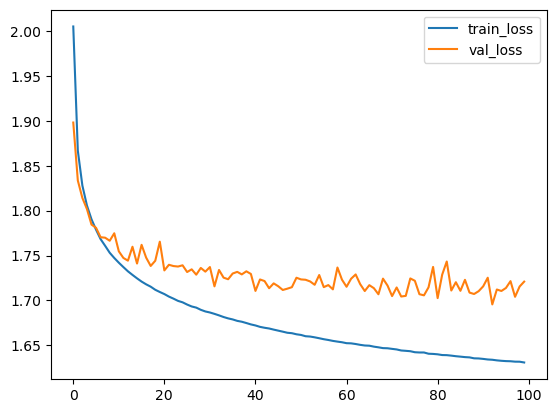

In [7]:
# Run on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

# set learning rate and weight decay
lr=1e-2
wd=1e-3
num_epochs = 100

model1 = SoftmaxRegression(3*32*32,10,lr=lr, wd=wd).to(device)
model1,train_loss,val_loss = train_model(model1,trainloader,valloader,num_epochs, device)
plt.plot(torch.arange(len(train_loss)),train_loss, label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss, label="val_loss")
plt.legend()
plt.show()

# Build models for various learning rates and weight decays
- model2: lr=1e-3, wd=1e-3, num_epochs = 100
- model3: lr=1e-3, wd=1e-2, num_epochs = 100
- model4: lr=1e-1, wd=1e-2, num_epochs = 100
- model5: lr=1e-5, wd=1e-2, num_epochs = 100

In [8]:
num_epochs = 100
# YOUR CODE HERE to build model2, model3, model4, model5
model2 = SoftmaxRegression(3*32*32,10,lr=1e-3, wd=1e-3).to(device)
model2, m2_train_loss, m2_val_loss = train_model(model2, trainloader, valloader, num_epochs, device)

model3 = SoftmaxRegression(3*32*32,10,lr=1e-3, wd=1e-2).to(device)
model3, m3_train_loss, m3_val_loss = train_model(model3, trainloader, valloader, num_epochs, device)

model4 = SoftmaxRegression(3*32*32,10,lr=1e-1, wd=1e-2).to(device)
model4, m4_train_loss, m4_val_loss = train_model(model4, trainloader, valloader, num_epochs, device)

model5 = SoftmaxRegression(3*32*32,10,lr=1e-5, wd=1e-2).to(device)
model5, m5_train_loss, m5_val_loss = train_model(model5, trainloader, valloader, num_epochs, device)


# Evaluate the performance of models (20 points)
- for each model, use the sklearn metrics functions to calculate on the test set
     - confusion matrix
     - accuracy
     - classification report
- build the function getTopKAcc() to calculate top_k_accuracy using the sklearn top_k_accuracy_score function with k = 1,2,3

In [9]:
# YOUR CODE to calculate CM, accuracy, classification report for model1,...,model5
models = [model1, model2, model3, model4, model5]

results = {}

for idx, model in enumerate(models, start = 1):
    model.eval()

    yhat_test = []
    ytrue_test = []

    # run model
    with torch.no_grad():
        for X_test, y_test in testloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            logit = model(X_test)
            pred = torch.argmax(logit, dim = 1)
            yhat_test.extend(pred.cpu().numpy())
            ytrue_test.extend(y_test.cpu().numpy())

    # convert to arrays
    yhat_test = np.array(yhat_test)
    ytrue_test = np.array(ytrue_test)

    # confusion matrix
    cm = confusion_matrix(ytrue_test, yhat_test)
    accuracy = accuracy_score(ytrue_test, yhat_test)
    cr = classification_report(ytrue_test, yhat_test, target_names = classes)

    results[f"model{idx}"] = {"cm": cm, "accuracy": accuracy, "report": cr}


In [10]:
results['model2']["accuracy"]

0.4058

In [11]:
def getTopKAcc(model, testloader, k=1):
    # YOUR CODE here to loop over the batches of test data to
    # calculate topK accuracy using the sklearn top_k_accuracy_score built in
    # remember to do all your work under torch.no_grad(), so that gradients of model are not updated!
    # return the top_k_accuracy score for the given model and test data set with the given k.
    yscore_test = []
    ytrue_test = []
    with torch.no_grad():
        for X_test, y_test in testloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            logit = model(X_test)
            yscore_test.extend(logit.cpu().numpy())
            ytrue_test.extend(y_test.cpu().numpy())

    yscore_test = np.array(yscore_test)
    ytrue_test = np.array(ytrue_test)
    top_k_acc = top_k_accuracy_score(ytrue_test, yscore_test, k = k, labels = list(range(10)))

    return top_k_acc


In [12]:
# YOUR CODE HERE to run the getTopKAcc function for testloader with the five models for k = 1,2,3
for idx, model in enumerate(models, start = 1):
    for k in [1,2,3]:
        print(f"Top {k} accuracy for model {idx}: {getTopKAcc(model, testloader, k)}")


Top 1 accuracy for model 1: 0.4094
Top 2 accuracy for model 1: 0.5992
Top 3 accuracy for model 1: 0.7187
Top 1 accuracy for model 2: 0.4058
Top 2 accuracy for model 2: 0.5988
Top 3 accuracy for model 2: 0.7193
Top 1 accuracy for model 3: 0.3871
Top 2 accuracy for model 3: 0.5745
Top 3 accuracy for model 3: 0.6972
Top 1 accuracy for model 4: 0.3718
Top 2 accuracy for model 4: 0.5709
Top 3 accuracy for model 4: 0.6967
Top 1 accuracy for model 5: 0.3785
Top 2 accuracy for model 5: 0.5728
Top 3 accuracy for model 5: 0.6968


# Best performing model (10 points)
- what is the learning rate and weight decay associated with the best performing model?
- comment on the effect of changing learning rate and weight decay on the basis of the five models you have built.
- use the visualization code below to understand the structure of the learned models under the different hyperparameters. Do you see a pattern in the coefficients as a function of learning rate, weight decay? Explain.

# Visualizing the learned models

In [13]:
# Visualize the learned weights for each class`

def visualize_model(model):
    theta = model.net[1].weight.data.cpu().numpy() # [10,3072]
    theta = theta.reshape(10, 3, 32, 32)  # Because we read the image as 3*32*32 instead of 32*32*3
    theta = np.transpose(theta, (0,2,3,1)) # [10,32,32,3], so plt can plot it

    theta_min, theta_max = np.min(theta), np.max(theta)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    plt.figure(figsize=(8,8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        # Rescale the weights to be between 0 and 255
        thetaimg = 255.0 * (theta[i] - theta_min) / (theta_max - theta_min)
        plt.imshow(thetaimg.astype('uint8'),cmap='viridis')
        plt.axis('off')
        plt.title(classes[i])

    plt.tight_layout()
    plt.show()

Model 1


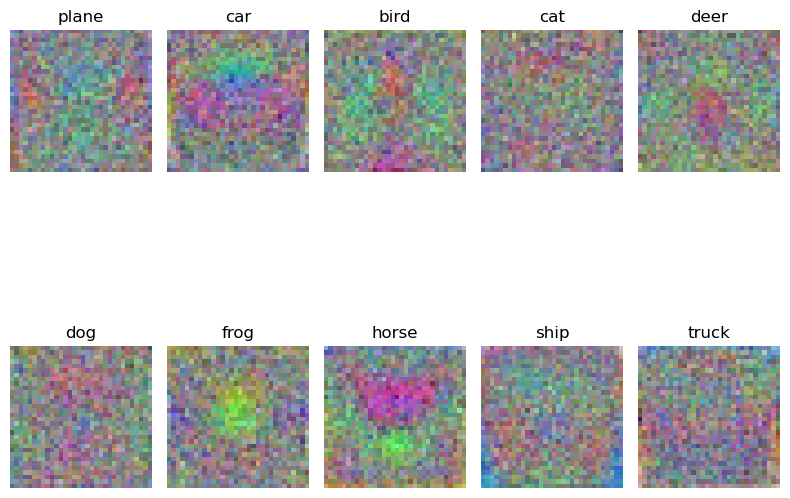

Model 2


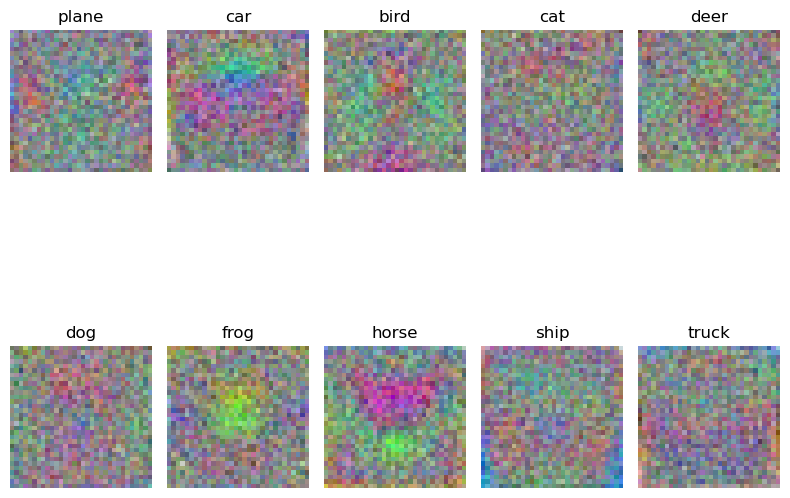

Model 3


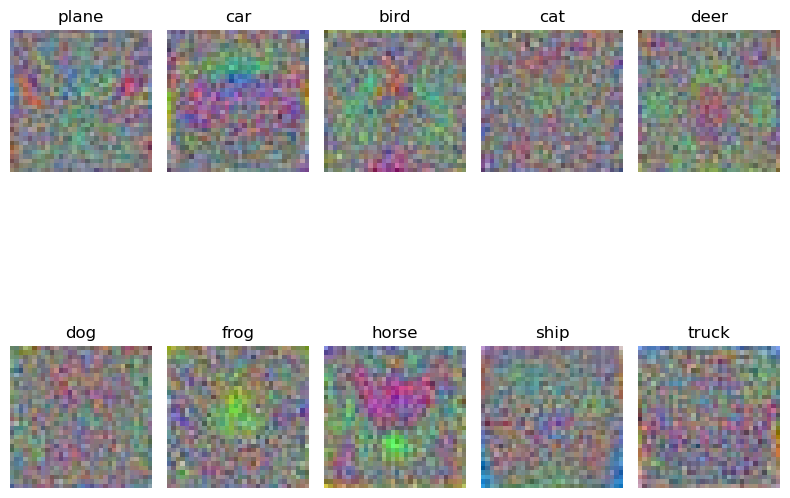

Model 4


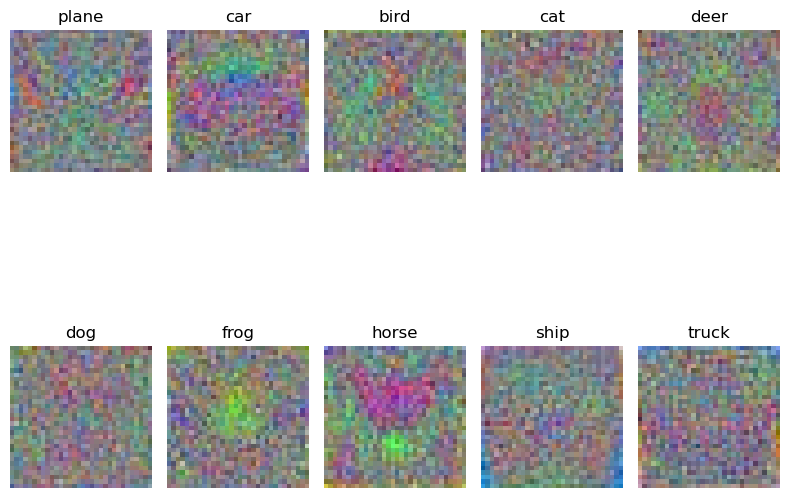

Model 5


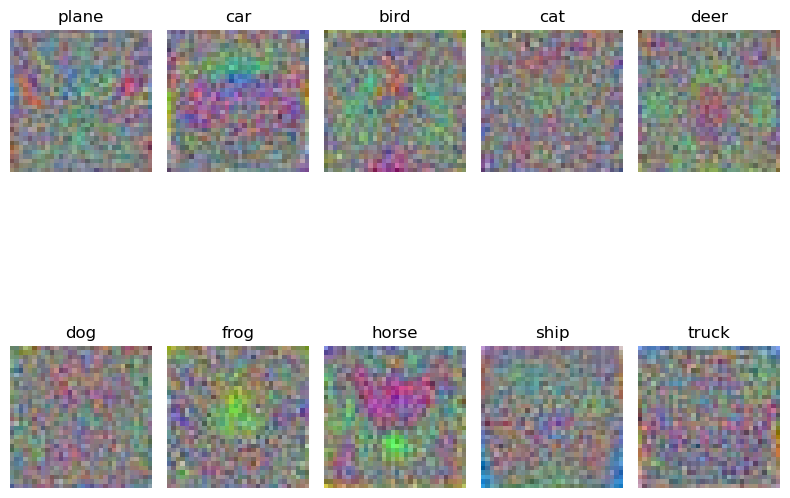

In [14]:
# YOUR CODE HERE for visualizing model1, ..., model5
# comment on what patterns you see
# Are the coefficients of the best performing model more interpretable than the others?
print("Model 1"); visualize_model(model1)
print("Model 2"); visualize_model(model2)
print("Model 3"); visualize_model(model3)
print("Model 4"); visualize_model(model4)
print("Model 5"); visualize_model(model5)

# In some of the visualizations of the coefficients, we can see outlines of the dominant features of the figure.
# The model performed the worst in identifying birds, cats, and deers. Even in the best model, it is difficult
# to interpret meaningful patterns in the model coefficients for these animals.

# The first two models perform the best relative to models 3-5.
# We definitely observe a noticeable difference in the coloring of the coefficients of models 1 and 2
# and the other 3 models. For example, the coefficients for the horse, car, and
# frog have much more concentrated masses in models 1-2 than in models 3-5.
# These coefficients are noticeably less distinct than the preferred models.


# More error analysis
- visualize errors made by the model
- we show the visual confusion matrix between categories cat and dog
- feel free to look at misclassifications between any pair of categories (look at the confusion matrix to find the objects most confused with another)

In [15]:
results["model1"]["cm"]

array([[481,  49,  42,  28,  21,  27,  26,  55, 193,  78],
       [ 60, 493,  19,  29,  21,  28,  40,  55,  74, 181],
       [ 93,  47, 267,  82, 119,  73, 157,  81,  54,  27],
       [ 43,  68,  85, 239,  61, 189, 152,  51,  43,  69],
       [ 57,  24, 121,  62, 286,  93, 185, 110,  27,  35],
       [ 47,  53,  90, 154,  77, 319,  90,  74,  59,  37],
       [ 22,  38,  62, 111,  80,  76, 515,  45,  17,  34],
       [ 52,  56,  58,  66,  78,  79,  48, 452,  35,  76],
       [133,  75,  22,  23,   9,  36,  10,  19, 551, 122],
       [ 63, 181,  18,  22,  20,  25,  48,  50,  82, 491]])

In [16]:
tmean = np.array([0.4914, 0.4822, 0.4465])
tstd = np.array([0.247, 0.243, 0.261])

def denormalize(img):
    """Undo CIFAR-10 normalization and convert to uint8 for imshow."""
    img = np.transpose(img, (1, 2, 0))           # CHW -> HWC
    img = (img * tstd + tmean) * 255.0
    return np.clip(img, 0, 255).astype(np.uint8)

# Get test data and predictions with model1

all_labels = []
all_preds = []
Xtest_list = [] # Use a list to store batches of test data

with torch.no_grad():
    for X,y in testloader:
        X, y = X.to(device), y.to(device)
        yhat = model1(X)
        Xtest_list.append(X) # Append test data batches
        all_labels.append(y)
        all_preds.append(yhat.argmax(dim=1))

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)
Xtest = torch.cat(Xtest_list) # Concatenate the list of batches


# Change cl_a and cl_b based on your  confusion matrix
# For example, from the confusion matrix of model1, classes 3 (cat) and 5 (dog) are confused

cl_a, cl_b = 3, 5 # Integer class labels

X_aa = Xtest[(all_labels == cl_a) & (all_preds == cl_a)]
X_ab = Xtest[(all_labels == cl_a) & (all_preds == cl_b)]
X_ba = Xtest[(all_labels == cl_b) & (all_preds == cl_a)]
X_bb = Xtest[(all_labels == cl_b) & (all_preds == cl_b)]

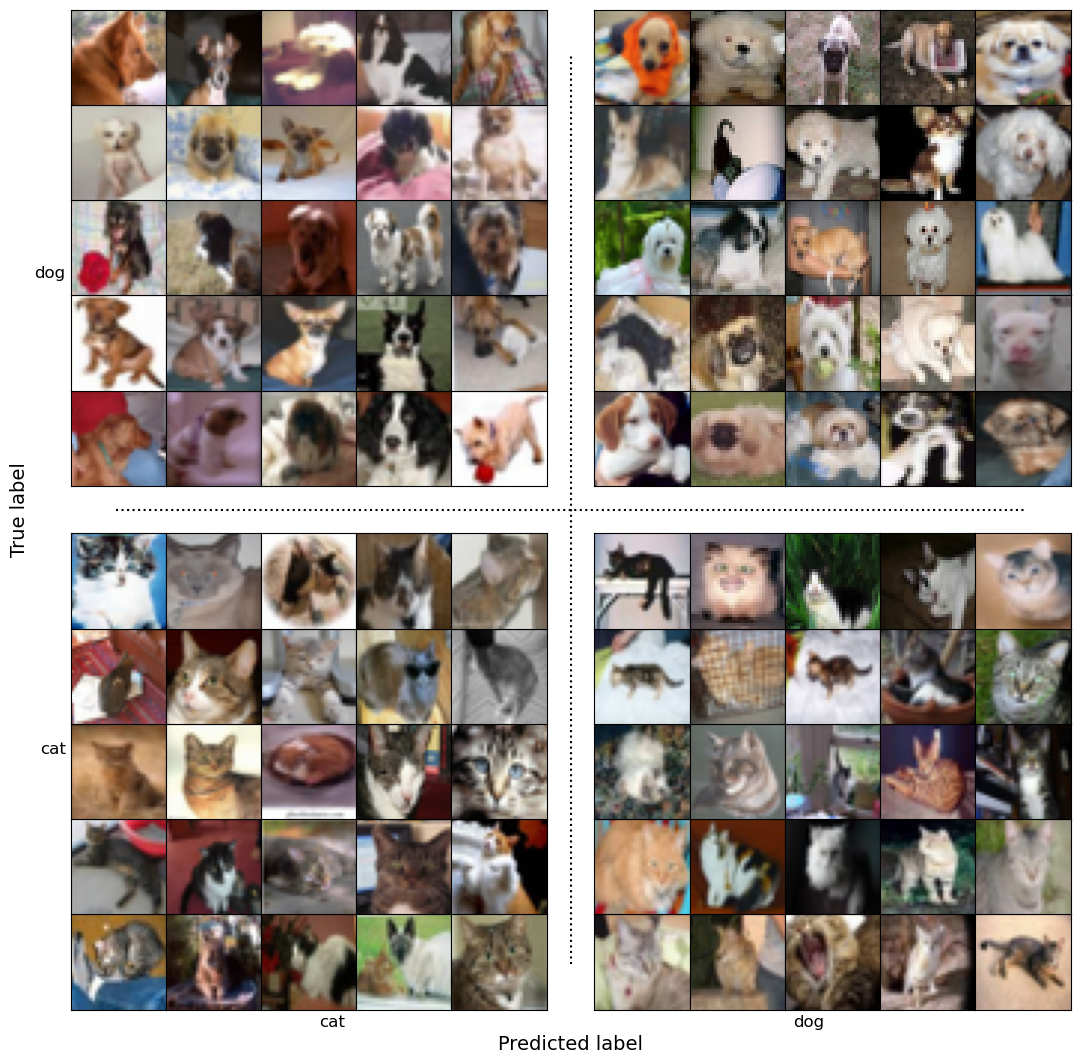

In [17]:
size = 5   # grid size inside each confusion block
pad = 0.5  # spacing between quadrants
total = 2 * size + pad  # logical grid size

fig = plt.figure(figsize=(size*2, size*2))

# Loop through quadrants
for images, (true_row, pred_col) in [
    (X_aa, (0, 0)),  # true A, pred A
    (X_ab, (0, 1)),  # true A, pred B
    (X_ba, (1, 0)),  # true B, pred A
    (X_bb, (1, 1)),  # true B, pred B
]:
    for idx, image_data in enumerate(images[:size*size]):
        # Grid position in "data units"
        x = idx % size + pred_col * (size + pad)
        y = idx // size + true_row * (size + pad)

        # Normalize to figure coords [0,1]
        ax = fig.add_axes([x / total,
                           y / total,
                           1 / total,
                           1 / total])

        img = denormalize(image_data.cpu().numpy())
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

# Add invisible overlay axis (in figure space)
ax_main = fig.add_axes([0, 0, 1, 1], frameon=False)
ax_main.set_xticks([ (size/2)/total, (size+pad+size/2)/total ])
ax_main.set_xticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

ax_main.set_yticks([ (size/2)/total, (size+pad+size/2)/total ])
ax_main.set_yticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

ax_main.set_xlabel("Predicted label", fontsize=14)
ax_main.set_ylabel("True label", fontsize=14)

# Hide tick marks and spines
ax_main.tick_params(axis='both', which='both', length=0)
for spine in ax_main.spines.values():
    spine.set_visible(False)

# Divider lines in normalized coords
ax_main.plot([ (size+pad/2)/total, (size+pad/2)/total ], [0,1], "k:")
ax_main.plot([0,1], [ (size+pad/2)/total, (size+pad/2)/total ], "k:")

plt.show()

# Comment below on the types of errors made by the model using the visualization above. What are common characteristics among dogs mistaken for cats and vice versa?

In [18]:
# YOUR COMMENTS HERE

# Several of the cats mistaken for dogs have wider heads and/or are not facing the camera directly.
# Many of these are looking away from the camera or are laying down. In contrast, many of the dogs mistaken for cats have pointy ears
# or are smaller in stature than the average dog. You can tell why the model struggled to correctly identify these images.

